# Time Series Predictions and Model Comparison 

## Import Libraries

In [460]:
# general
import pandas as pd
import numpy as np 
import datetime
import statistics

# plots
import seaborn as sns
import matplotlib.colors as mpl_col
import matplotlib.pyplot as plt
sns.set()

#machine learning and statistical methods
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# settings
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (16, 8)

## Load Data

In [269]:
# ride-hailing demand data
df = pd.read_csv("total_rides_18_19.csv", sep=",", index_col=0)

In [472]:
df['nb_rides'].mean()

728693.4715151516

In [474]:
(55000/728693)*100

7.547760167862186

In [270]:
# preprocessing
# convert date to datetime
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

# sort by date
df.sort_values(by=['date'], inplace=True)

# add month and year as seperate columns
df['year'] = pd.to_datetime(df['date']).dt.year
df['month'] = pd.to_datetime(df['date']).dt.month

# add weekday information
df['week_day'] = pd.to_datetime(df['date']).dt.strftime('%A')

# change invalid counts
df.loc[df['nb_rides']<100000, 'nb_rides'] = 650000

In [271]:
# split in train and test
start_date = '2018-01-01'
split_date = '2020-02-01'
end_date = '2020-03-01'
df_train = df[df['date']<split_date][['date','nb_rides', 'week_day']].copy()
df_test = df[(df['date']>=split_date) & (df['date']<=end_date)][['date','nb_rides', 'week_day']].copy()

print(f"The train set contains {df_train.shape[0]} obervations from {start_date} to {split_date}")
print(f"The test set contains {df_test.shape[0]} obervations from {split_date} to {end_date}")

The train set contains 765 obervations from 2018-01-01 to 2020-02-01
The test set contains 30 obervations from 2020-02-01 to 2020-03-01


In [272]:
df

,date,nb_rides,year,month,week_day
0,2018-01-01,702084.0,2018,1,Monday
1,2018-01-02,547447.0,2018,1,Tuesday
2,2018-01-03,583735.0,2018,1,Wednesday
3,2018-01-04,354626.0,2018,1,Thursday
4,2018-01-05,699966.0,2018,1,Friday
...,...,...,...,...,...
820,2020-03-27,184297.0,2020,3,Friday
821,2020-03-28,156564.0,2020,3,Saturday
822,2020-03-29,127639.0,2020,3,Sunday
823,2020-03-30,154304.0,2020,3,Monday


## Cross Validation Datasets

Create 5 datasets to test models at different points in time. <br>
Get testing set at different points during the year. <br>
Breakt dates:
 - 2020.03.01
 - 2020.06.01
 - 2020.09.01
 - 2020.12.01
 - 2021.02.01

In [273]:
# create 10 training datasets
df_train_1 = df[df['date']<'2019-03-01']
df_test_1 = df[df['date']>='2019-03-01']

df_train_2 = df[df['date']<'2019-04-15']
df_test_2 = df[df['date']>='2019-04-15']

df_train_3 = df[df['date']<'2019-06-01']
df_test_3 = df[df['date']>='2019-06-01']

df_train_4 = df[df['date']<'2019-07-15']
df_test_4 = df[df['date']>='2019-07-15']

df_train_5 = df[df['date']<'2019-09-01']
df_test_5 = df[df['date']>='2019-09-01']

df_train_6 = df[df['date']<'2019-10-15']
df_test_6 = df[df['date']>='2019-10-15']

df_train_7 = df[df['date']<'2019-12-01']
df_test_7 = df[df['date']>'2019-12-01']

df_train_8 = df[df['date']<'2019-01-15']
df_test_8 = df[df['date']>='2019-01-15']

df_train_9 = df[df['date']<'2020-02-01']
df_test_9 = df[df['date']>='2020-02-01']

## Naive Model

Predicts the last observed value of the same season of the year. <br>
In this case there are 2 seasonalities: weekly and yearly. <br> <br>
Method 1: <br>
- Weekly moving average: take average of last 4 weekdays

Method 2:
- Take average value of that weekday, same month but one year before

### Moving average

In [274]:
def mov_avg_predict(df):
    '''
    Predicts demand of ride-hailing services for next 7 days.
    For each weekday to be predicted, it takes the average of the last 4 values of the same weekday
    '''
    # first future date to be predicted 
    start_date = df.iloc[-1]['date'] + datetime.timedelta(days=1)
    # get list of next 7 dates
    pred_dates = pd.date_range(start=start_date,end=start_date + datetime.timedelta(days=6)).to_pydatetime().tolist()
    # create empty list for predictions
    pred_values = []

    for i in range(7):
        # get starting date of moving average
        avg_start_date = pred_dates[i] - datetime.timedelta(days=28)
        avg_end_date = pred_dates[i] - datetime.timedelta(days=7)
        # get 5 dates of moving average
        mov_avg_dates = pd.date_range(start=avg_start_date, end=avg_end_date, periods=7).to_pydatetime().tolist()
        # get mean nb_rides from moving average dates 
        mov_avg_pred = df_train[df_train['date'].isin(mov_avg_dates)]['nb_rides'].mean()
        # append to pred list
        pred_values.append(mov_avg_pred)

    # create dataframe with next 7 dates to be predicted 
    df_pred = pd.DataFrame({'pred_date': pred_dates, 'pred_nb_rides': pred_values})
    # add weekday information
    df_pred['week_day'] = pd.to_datetime(df_pred['pred_date']).dt.strftime('%A')

    return df_pred

In [325]:
def eval_mov_avg(df_train, df_test, plot=True):
    # get prediction dataframe 
    df_pred = mov_avg_predict(df_train)

    # get predicted values and true values
    true_values = df_test[:7]['nb_rides'].values
    true_values_dates = df_test[:7]['date'].values
    predictions = df_pred[:7]['pred_nb_rides'].values
    pred_dates = df_pred[:7]['pred_date'].values

    # evaluate forecasts
    rmse = np.sqrt(mean_squared_error(true_values, predictions))
    
    # evaluate forecasts with mae for mase comparison
    mae  = np.mean(np.abs(true_values - predictions))

    if plot:
        print('Test RMSE: %.3f' % rmse)
        # plot forecasts against actual outcomes
        plt.plot(true_values_dates, true_values, label='True Value')
        plt.plot(pred_dates, predictions, color='red', label='Predicted Value')
        plt.xlabel('date')
        plt.ylabel('number of rides')
        plt.legend()
        plt.title(f"Seasonal Moving Average from {df_test.iloc[0]['date']} to {df_test.iloc[7]['date']} ")
        plt.show();
        
    return rmse, mae

Test RMSE: 69488.798


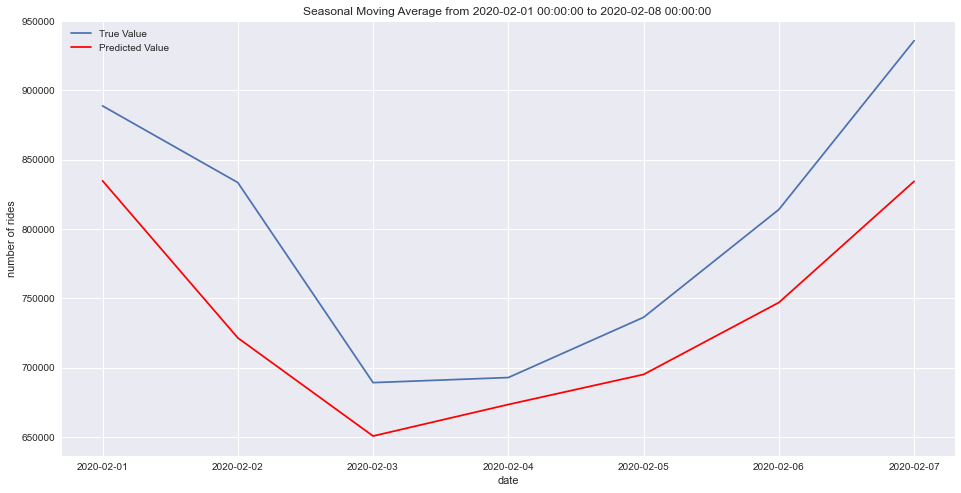

69488.7982447531

In [307]:
eval_mov_avg(df_train_9, df_test_9, plot=True)

In [308]:
# list of training datasets
train_sets = [df_train_1, df_train_2, df_train_3, df_train_4, df_train_5, df_train_6, df_train_7, df_train_8, df_train_9]
test_sets = [df_test_1, df_test_2, df_test_3, df_test_4, df_test_5, df_test_6, df_test_7, df_test_8, df_test_9]

In [333]:
rmse_list = []
mae_list = []
for i in range(len(train_sets)):
    rmse, mae = eval_mov_avg(train_sets[i], test_sets[i], plot=False)
    rmse_list.append(rmse)
    mae_list.append(mae)

In [334]:
rmse_list

[45024.383459132456,
 55493.34595278712,
 27743.537919570437,
 60268.19367894526,
 32868.63350290387,
 55077.6425675123,
 90608.13925665602,
 60645.960437034526,
 69488.7982447531]

In [335]:
statistics.mean(rmse_list)

55246.5150021439

In [336]:
statistics.stdev(rmse_list)

18938.793240053612

## SARIMA

In [19]:
# fit model
model = SARIMAX(endog=df_train_5['nb_rides'].values, order=(1,1,2), seasonal_order=(7,1,2,7))
model_fit = model.fit()
# multi-step out-of-sample forecast
forecast = model_fit.forecast(steps=7)

/Users/marthab/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


In [11]:
forecast

array([920379.05817368, 784259.11301335, 706132.41037341, 732082.61629439,
       745055.97163054, 779472.43701261, 866603.73705608])

In [12]:
df_test_5[:7]

,date,nb_rides,year,month,week_day
765,2020-02-01,888762.0,2020,2,Saturday
766,2020-02-02,833486.0,2020,2,Sunday
767,2020-02-03,689217.0,2020,2,Monday
768,2020-02-04,692876.0,2020,2,Tuesday
769,2020-02-05,736319.0,2020,2,Wednesday
770,2020-02-06,814061.0,2020,2,Thursday
771,2020-02-07,935778.0,2020,2,Friday


Test RMSE: 40185.279


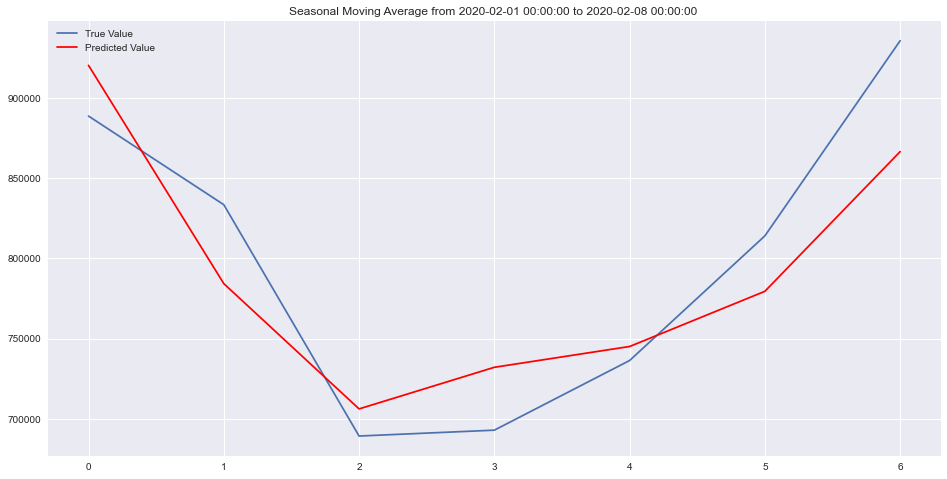

40185.27920938054

In [16]:
eval_7days(df_test_5, forecast)

In [464]:
def eval_sarima(df_train, df_test, steps=7, plot=True):
    # get prediction dataframe 
    # fit model
    model = SARIMAX(endog=df_train['nb_rides'].values, order=(1, 1, 1), seasonal_order=(2, 1, 1, 7))
    model_fit = model.fit() 
    # multi-step out-of-sample forecast
    forecast = model_fit.forecast(steps=steps)
    
    # get predicted values and true values
    true_values = df_test[:steps]['nb_rides'].values
    true_values_dates = df_test[:steps]['date'].values
    predictions = forecast

    # evaluate forecasts with
    rmse = np.sqrt(mean_squared_error(true_values, predictions))
    
    # evaluate forecasts with mae for mase comparison
    mae  = np.mean(np.abs(true_values - predictions))

    if plot:
        print('Test RMSE: %.3f' % rmse)
        # plot forecasts against actual outcomes
        plt.plot(true_values_dates, true_values, label='True Value')
        plt.plot(true_values_dates, predictions, color='red', label='Predicted Value')
        plt.legend()
        plt.title(f"SARIMA predictions from {df_test.iloc[0]['date']} to {df_test.iloc[steps]['date']} ")
        plt.gca().set(ylabel='number of rides', xlabel='date')
        plt.show();
        
    return rmse, mae

Test RMSE: 40744.951


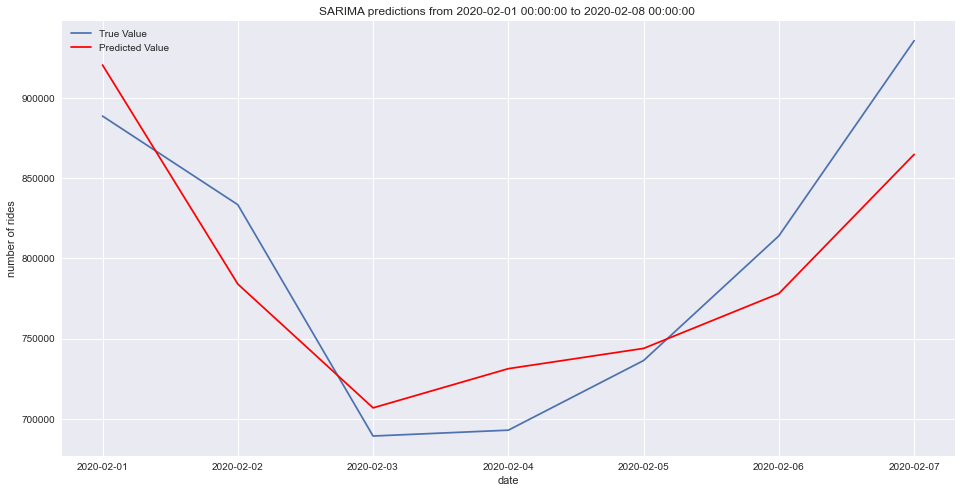

40744.95052499493

In [317]:
eval_sarima(df_train_9, df_test_9)

Test RMSE: 43289.679


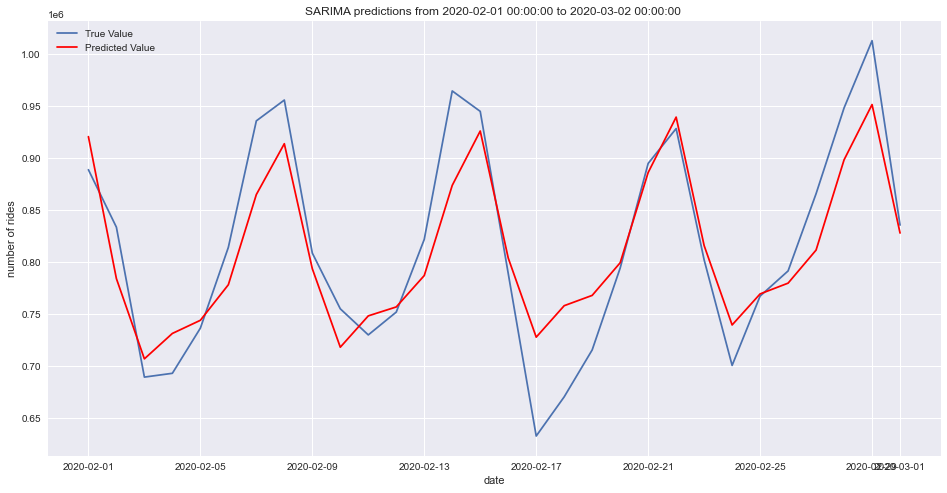

(43289.67906710145, 34276.57618681767)

In [465]:
eval_sarima(df_train_9, df_test_9, steps=30)

In [467]:
rmse_list_sarima_30 = []
mae_list_sarima_30 = []
for i in range(len(train_sets)):
    rmse, mae = eval_sarima(train_sets[i], test_sets[i], steps=30, plot=False)
    rmse_list_sarima_30.append(rmse)
    mae_list_sarima_30.append(mae)

In [469]:
statistics.mean(rmse_list_sarima_30)

81891.96759335647

In [319]:
rmse_list_sarima = []
mae_list_sarima = []
for i in range(len(train_sets)):
    rmse, mae = eval_sarima(train_sets[i], test_sets[i], plot=False)
    rmse_list_sarima.append(rmse)
    mae_list_sarima.append(mae)

In [146]:
rmse_list_sarima

[43478.769522091185,
 59691.86567744824,
 29179.26397811783,
 58598.38781642827,
 36533.210619850484,
 65217.174148257865,
 209550.3463749332,
 25675.502750173495,
 40744.95052499493]

In [147]:
statistics.mean(rmse_list_sarima)

63185.496823588386

In [148]:
statistics.stdev(rmse_list_sarima)

56596.97985680978

### SARIMA parameter set up

p/P : number of autoregressive terms <br>
d/D : number of differencing to stationarize series <br>
q/Q : number of moving average terms (lags of forecast error) <br>
s : seasonal length of data

s = 7, because of weekly seasonality 

look at ACF and PACF graph to initiate parameters:

''

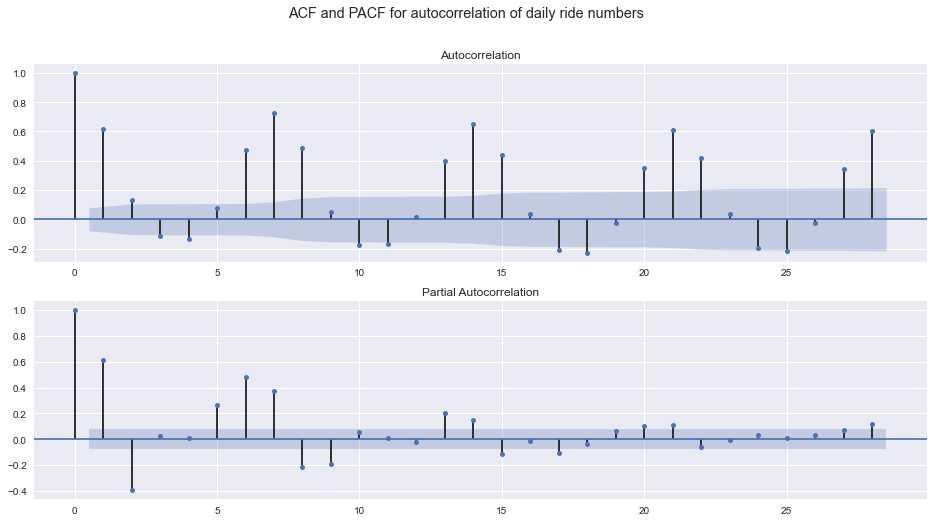

In [43]:
fig, ax = plt.subplots(2)
plot_acf(df_train_5['nb_rides'], ax=ax[0])
plot_pacf(df_train_5['nb_rides'], ax=ax[1])
fig.suptitle(f"ACF and PACF for autocorrelation of daily ride numbers")
;

In [74]:
model = SARIMAX(endog=df_train_5['nb_rides'].values, order=(1,1,1), seasonal_order=(1,0,0,7)).fit(max_iter=50, method='powell')
res = model.resid

Optimization terminated successfully.
         Current function value: 12.324489
         Iterations: 5
         Function evaluations: 268


''

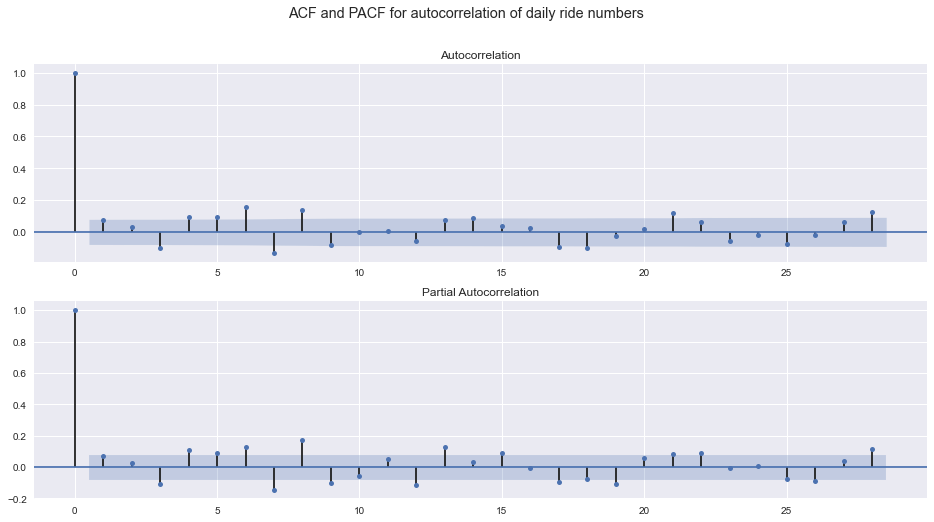

In [75]:
fig, ax = plt.subplots(2)
plot_acf(res, ax=ax[0])
plot_pacf(res, ax=ax[1])
fig.suptitle(f"ACF and PACF for autocorrelation of daily ride numbers")
;

### SARIMA Hyperparameter Tuning

In [114]:
import itertools
#set parameter range
p = range(0,3)
q = range(0,3)
d = range(1,2)
s = range(7,8)
# list of all parameter combos
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(p, d, q, s))
# empty dict to save results
sarima_dict_aic = {}
sarima_dict_rmse = {}
# SARIMA model pipeline
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(endog=df_train_5['nb_rides'].values,
                          order=param,
                          seasonal_order=param_seasonal)
            model_fit = mod.fit(max_iter = 50, method = 'powell')
            forecast = model_fit.forecast(steps=7)

            # get predicted values and true values
            true_values = df_test_5[:7]['nb_rides'].values
            predictions = forecast

            # evaluate forecasts
            rmse = np.sqrt(mean_squared_error(true_values, predictions))
            sarima_dict_rmse[rmse] = f'{param}, {param_seasonal}'
            sarima_dict_aic[model_fit.aic] = f'{param}, {param_seasonal}'
            #print('SARIMA{},{} - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

Optimization terminated successfully.
         Current function value: 12.310003
         Iterations: 1
         Function evaluations: 12
Optimization terminated successfully.
         Current function value: 12.160950
         Iterations: 1
         Function evaluations: 25
Optimization terminated successfully.
         Current function value: 12.153622
         Iterations: 2
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: 12.220916
         Iterations: 2
         Function evaluations: 50
Optimization terminated successfully.
         Current function value: 12.154189
         Iterations: 3
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: 12.153648
         Iterations: 2
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: 12.174835
         Iterations: 2
         Function evaluations: 73
Optimization terminated successfu

Optimization terminated successfully.
         Current function value: 12.124323
         Iterations: 2
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: 12.106513
         Iterations: 5
         Function evaluations: 365
Optimization terminated successfully.
         Current function value: 12.106789
         Iterations: 3
         Function evaluations: 249
Optimization terminated successfully.
         Current function value: 12.242050
         Iterations: 2
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: 12.098707
         Iterations: 2
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: 12.091634
         Iterations: 3
         Function evaluations: 215
Optimization terminated successfully.
         Current function value: 12.154844
         Iterations: 2
         Function evaluations: 117
Optimization terminated succ

In [115]:
sarima_dict_aic[min(sarima_dict_aic)]

'(1, 1, 1), (1, 1, 1, 7)'

In [116]:
sarima_dict_rmse[min(sarima_dict_rmse)]

'(2, 1, 2), (0, 1, 0, 7)'

In [53]:
model = SARIMAX(endog=df_train_5['nb_rides'].values, order=(1,1,1), seasonal_order=(2,1,1,7)).fit(max_iter=50, method='powell')
res = model.resid

Optimization terminated successfully.
         Current function value: 12.088190
         Iterations: 4
         Function evaluations: 297


''

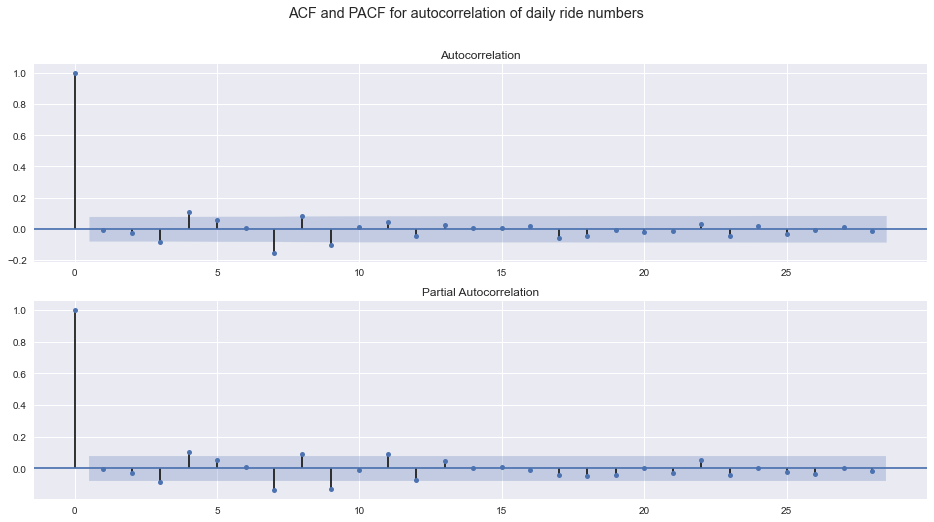

In [54]:
print()
fig, ax = plt.subplots(2)
plot_acf(res, ax=ax[0])
plot_pacf(res, ax=ax[1])
fig.suptitle(f"ACF and PACF for autocorrelation of daily ride numbers")
;

In [26]:
#extracting weekly seasonality from raw time series
sd_7 = sm.tsa.seasonal_decompose(df_train_5['nb_rides'].values, model='additive', period=7)

/Users/marthab/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


''

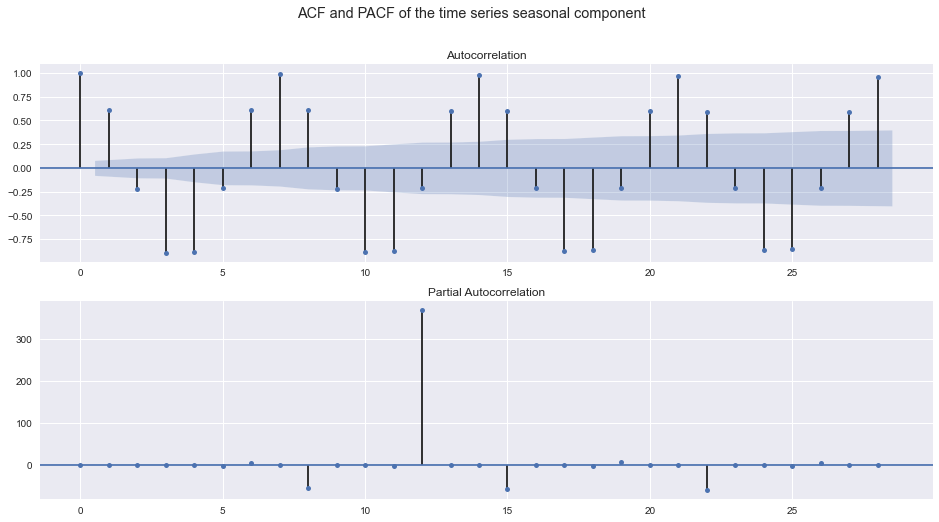

In [111]:
fig, ax = plt.subplots(2)
plot_acf(sd_7.seasonal, ax=ax[0])
plot_pacf(sd_7.seasonal, ax=ax[1])
fig.suptitle(f"ACF and PACF of the time series seasonal component")
;

In [73]:
from statsmodels.tsa.stattools import adfuller, kpss

# ADF Test
result = adfuller(sd_7.seasonal, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -2278113625202547.0
p-value: 0.0
Critial Values:
   1%, -3.441444394224128
Critial Values:
   5%, -2.8664345376276454
Critial Values:
   10%, -2.569376663737217


In [98]:
model = SARIMAX(endog=df_train_5['nb_rides'].values, order=(0,1,0), seasonal_order=(0,0,0,0)).fit(max_iter=50, method='powell')
res = model.resid

Optimization terminated successfully.
         Current function value: 12.665212
         Iterations: 1
         Function evaluations: 11


In [99]:
# plot entire time series of one store
def plot_df(x, y, title="", xlabel='Date', ylabel='Number of Drives', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:blue')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

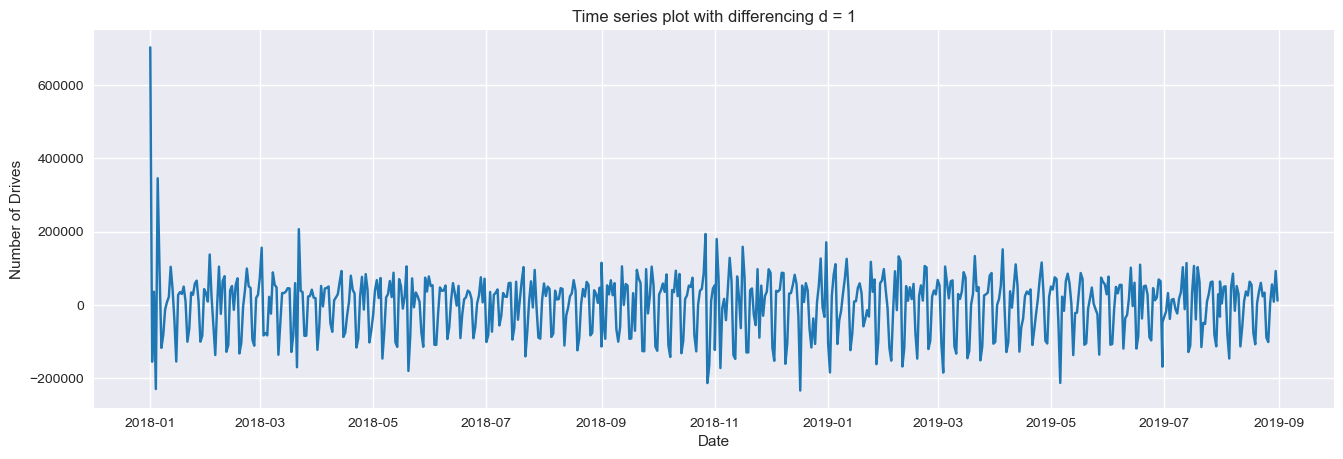

In [100]:
plot_df(df_train_5['date'], res, title = 'Time series plot with differencing d = 1')

In [101]:
from statsmodels.tsa.stattools import adfuller, kpss

# ADF Test
result = adfuller(res, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -8.744113802260943
p-value: 2.954399457726077e-14
Critial Values:
   1%, -3.441444394224128
Critial Values:
   5%, -2.8664345376276454
Critial Values:
   10%, -2.569376663737217


''

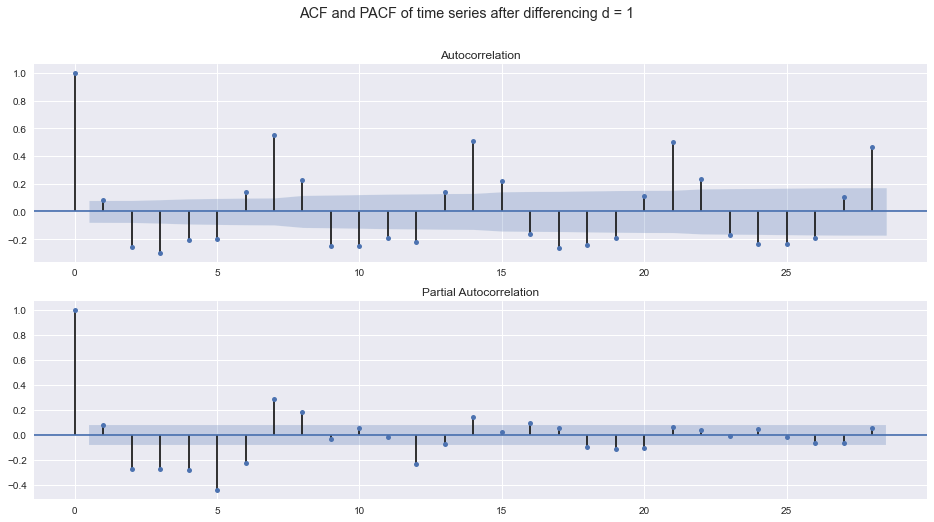

In [103]:
fig, ax = plt.subplots(2)
plot_acf(res, ax=ax[0])
plot_pacf(res, ax=ax[1])
fig.suptitle(f"ACF and PACF of time series after differencing d = 1")
;

In [328]:
# MASE, comparision with baseline model
def mase(baseline_mae_list, model_mae_list):
    mase_list = []
    for i in range(len(baseline_mae_list)):
        mase = model_mae_list[i]/baseline_mae_list[i]
        mase_list.append(mase)
        
    avg_mase = statistics.mean(mase_list)

    return avg_mase

In [337]:
mae_list

[40213.71428571428,
 46872.0,
 22300.39285714286,
 49860.485714285714,
 30998.535714285714,
 41419.75,
 84977.42857142857,
 57381.82142857143,
 61947.78571428572]

In [330]:
mae_list_sarima

[30166.806742320354,
 47966.25770387998,
 21229.1604280604,
 49896.07084239383,
 27531.290869949204,
 54266.60180208479,
 194845.13116707632,
 25196.493916867483,
 35953.04450661993]

In [338]:
avg_mase_sarima = mase(mae_list, mae_list_sarima)
avg_mase_sarima

1.0263198997094256

## Prophet

In [162]:
def prophet_prep(df_train, df_test):
    # rename columns to fit prophet model 
    df_train_proph = df_train[['date', 'nb_rides']].copy()
    df_train_proph.columns = ['ds', 'y']
    df_test_proph = df_test[['date', 'nb_rides']].copy()
    df_test_proph.columns = ['ds', 'y']
    return df_train_proph, df_test_proph

In [345]:
# prep dataset for prophet requirements
df_train_p, df_test_p = prophet_prep(df_train_9, df_test_9)

In [346]:
# fit Prophet model
model = Prophet()
model.fit(df_train_p)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/marthab/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


In [347]:
# initialise future dataset for predictions 
# extends into the future a specified number of days, including historical dates
future = model.make_future_dataframe(periods=7)

In [348]:
# make predictions
# fits model to historical values and future values
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].iloc[-7:]

/Users/marthab/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/marthab/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


,ds,yhat,yhat_lower,yhat_upper
761,2020-02-01,882169.032312,819181.755329,940698.366916
762,2020-02-02,776493.383016,717805.535252,834549.860441
763,2020-02-03,681060.497526,621829.532912,738436.162873
764,2020-02-04,696017.788691,639971.229036,755523.662589
765,2020-02-05,714885.535112,659781.037834,771567.091092
766,2020-02-06,747334.591696,687847.288075,806764.002492
767,2020-02-07,811942.566816,756365.849758,867151.917407


In [190]:
df_test_p[:7]['y'].values

array([697475., 574157., 606322., 647563., 687542., 812278., 822808.])

In [353]:
365*2

730

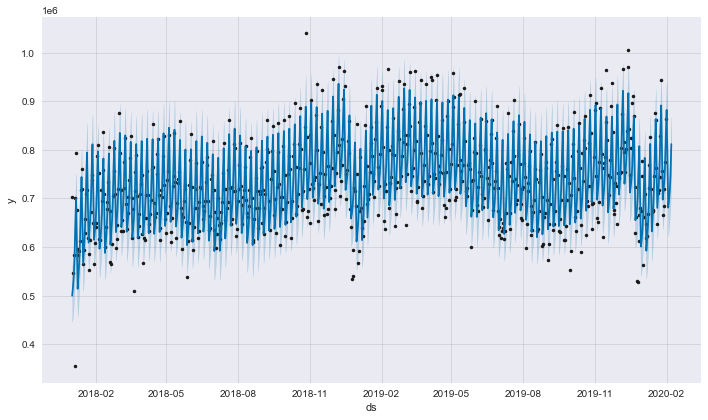

In [349]:
# plot forecasts
fig1 = model.plot(forecast)

In [ ]:
rmse = np.sqrt(mean_squared_error(true_values, predictions))

In [461]:
def eval_prophet(df_train, df_test, holidays=False, periods=7, cap=0, plot=True):
    
    # prep datasets for Prophet
    df_train_p, df_test_p = prophet_prep(df_train, df_test)
    
    # define growth model (linear or logistic)
    if cap > 0:
        df_train_p['cap'] = cap
        model = Prophet(growth='logistic')
    else:
        model = Prophet(growth='linear')

    # add holidays 
    if holidays:
        model.add_country_holidays(country_name='US')
        
    # fit model 
    model.fit(df_train_p)
    
    # initialise future dataset for predictions
    future = model.make_future_dataframe(periods=periods) # extends into the future a specified number of days, including historical dates
    if cap > 0:
        future['cap'] = cap
    
    # make predictions
    forecast = model.predict(future) # fits model to historical values and future values
    
    # get predicted values and true values
    true_values = df_test_p[:periods]['y'].values
    true_values_date = df_test_p[:periods]['ds'].values
    predictions = forecast[-periods:]['yhat'].values

    # evaluate forecasts
    rmse = np.sqrt(mean_squared_error(true_values, predictions))
    
    # evaluate forecasts with mae for mase comparison
    mae  = np.mean(np.abs(true_values - predictions))

    if plot:
        print('Test RMSE: %.3f' % rmse)
        # plot forecasts against actual outcomes
        plt.plot(true_values_date, true_values, label='True Value')
        plt.plot(true_values_date, predictions, color='red', label='Predicted Value')
        plt.xticks(rotation = 45)
        plt.legend()
        plt.title(f"Prophet predictions from {df_test_p.iloc[0]['ds']} to {df_test_p.iloc[periods]['ds']} ")
        plt.gca().set(ylabel='number of rides', xlabel='date')
        plt.show();
        
    return rmse, mae

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/marthab/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/marthab/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/marthab/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Test RMSE: 58082.511


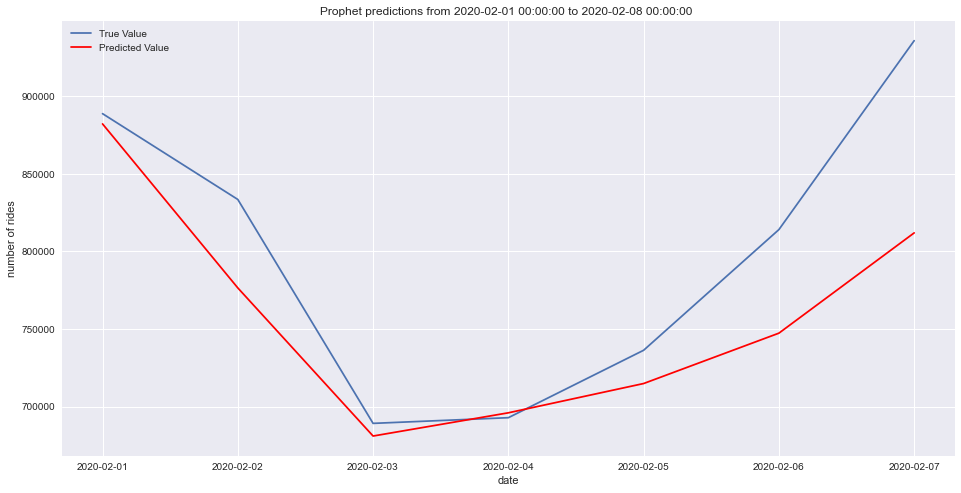

(58082.510862330266, 40982.740316178846)

In [427]:
eval_prophet(df_train_9, df_test_9)

In [448]:
rmse_list_prophet = []
mae_list_prophet = []
for i in range(len(train_sets)):
    rmse, mae = eval_prophet(train_sets[i], test_sets[i], cap=1022363, plot=False)
    rmse_list_prophet.append(rmse)
    mae_list_prophet.append(mae)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/marthab/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/marthab/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/marthab/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbp

In [449]:
statistics.mean(rmse_list_prophet)

52841.32879375869

In [450]:
statistics.stdev(rmse_list_prophet)

22716.95301181113

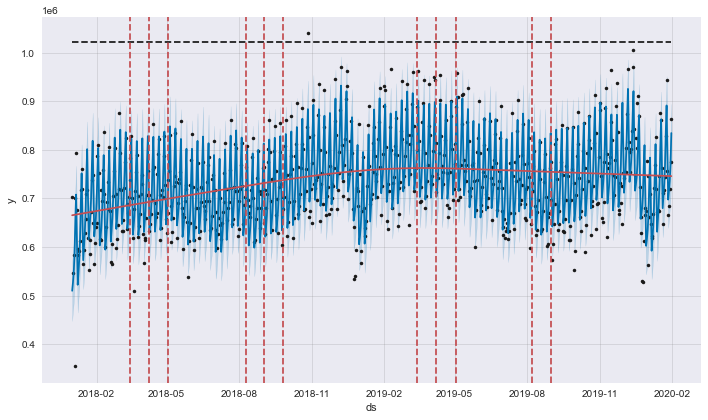

In [451]:
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

### Prophet add holidays

In [357]:
# prep datasets for Prophet
df_train_p, df_test_p = prophet_prep(df_train_9, df_test_9)

# fit Prophet model
model = Prophet()
model.add_country_holidays(country_name='US')
model.fit(df_train_p)

# initialise future dataset for predictions 
future = model.make_future_dataframe(periods=7) # extends into the future a specified number of days, including historical dates

# make predictions
forecast = model.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/marthab/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/marthab/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/marthab/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/marthab/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/marthab/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/marthab/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Test RMSE: 55960.399


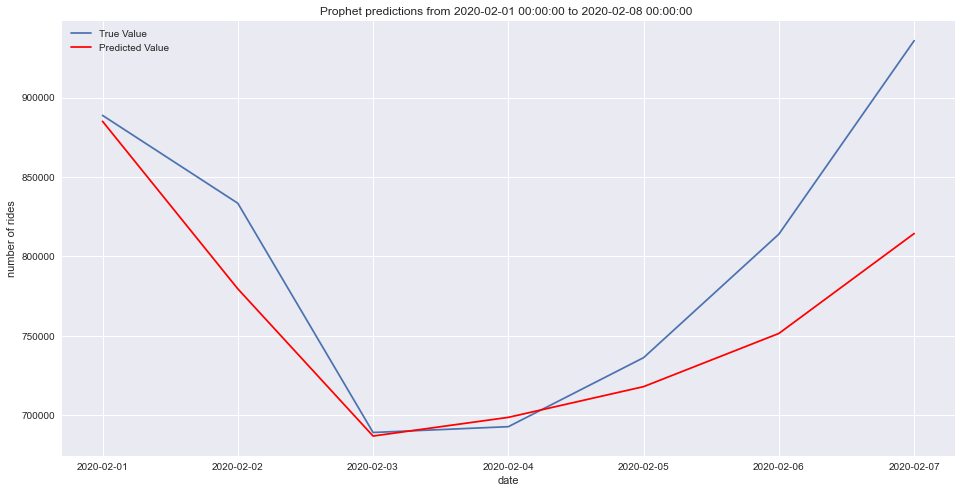

55960.39945127034

In [358]:
eval_prophet(df_train_9, df_test_9, holidays=True)

In [359]:
rmse_list_prophet = []
for i in range(len(train_sets)):
    rmse = eval_prophet(train_sets[i], test_sets[i], season_mode='additive', holidays=True, plot=False)
    rmse_list_prophet.append(rmse)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/marthab/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/marthab/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/marthab/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbp

/Users/marthab/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/marthab/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


In [361]:
statistics.mean(rmse_list_prophet)

54133.100132621286

In [362]:
statistics.stdev(rmse_list_prophet)

22423.029116608202

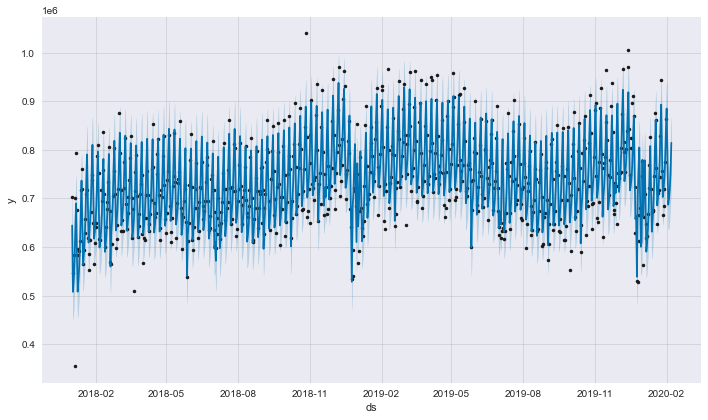

In [222]:
fig = model.plot(forecast)

/Users/marthab/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/marthab/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


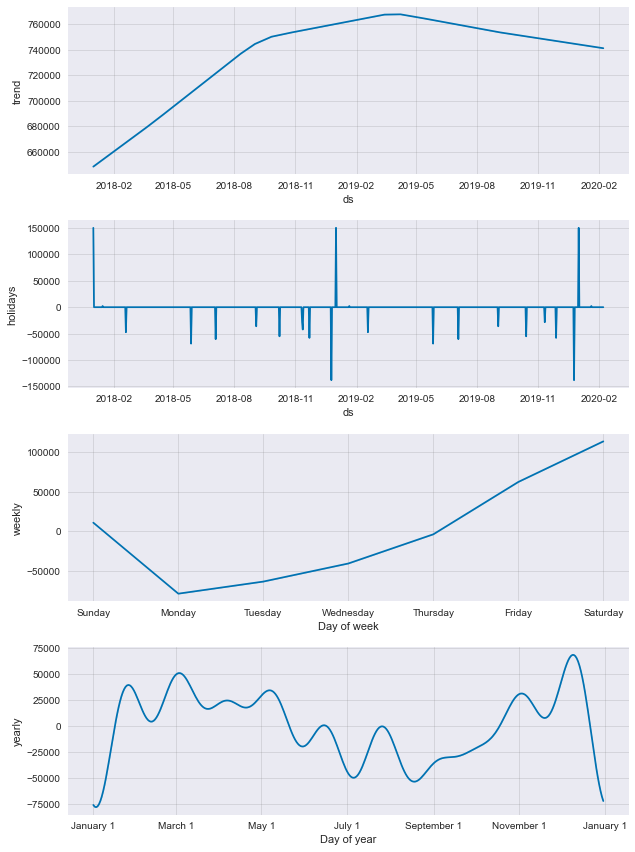

In [363]:
fig = model.plot_components(forecast)

### Prophet Cross-Validation

In [235]:
from prophet.diagnostics import cross_validation
df_cv = cross_validation(model, period='30 days', horizon = '7 days') # period = spacing between cutoffs

INFO:prophet:Making 13 forecasts with cutoffs between 2019-01-29 00:00:00 and 2020-01-24 00:00:00


  0%|          | 0/13 [00:00<?, ?it/s]

/Users/marthab/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/marthab/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/marthab/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/marthab/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inst

/Users/marthab/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/marthab/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/marthab/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/marthab/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inst

In [239]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,1 days,4.495997e+09,67052.197067,44178.549203,0.065882,0.048616,0.061505,0.846154
1,2 days,4.542797e+09,67400.277918,47292.743731,0.067060,0.043607,0.063849,0.785714
2,3 days,3.385507e+09,58185.109880,39374.676089,0.054974,0.027195,0.052543,0.785714
3,4 days,5.293192e+09,72754.326719,53764.260147,0.080584,0.057665,0.075055,0.692308
4,5 days,3.619861e+09,60165.276940,42941.253297,0.059391,0.041336,0.056986,0.769231
5,6 days,5.245080e+09,72422.921668,63241.177437,0.082881,0.080059,0.084087,0.461538
6,7 days,5.121101e+09,71561.870297,54387.111043,0.076693,0.045835,0.073156,0.692308


### Prophet hyperparameter tuning

In [438]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.05, 0.1, 0.5], # default = 0.05
    'seasonality_prior_scale': [1.0, 10.0, 15.0],
    'seasonality_mode': ['additive', 'multiplicative'],
    'growth': ['logistic']
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# with cap
df_train_p['cap']=1022363

# Use cross validation to evaluate all parameters
for params in all_params:
    model = Prophet(**params).fit(df_train_p)  # Fit model with given params
    df_cv = cross_validation(model, period='30 days', horizon = '7 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/marthab/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:prophet:Making 13 forecasts with cutoffs between 2019-01-29 00:00:00 and 2020-01-24 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fee3efe2b50>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/marthab/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:prophet:Making 13 forecasts with cutoffs between 2019-01

INFO:prophet:Making 13 forecasts with cutoffs between 2019-01-29 00:00:00 and 2020-01-24 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fee6bd74790>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/marthab/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:prophet:Making 13 forecasts with cutoffs between 2019-01-29 00:00:00 and 2020-01-24 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fee54e8b160>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/marthab/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.a

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/marthab/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:prophet:Making 13 forecasts with cutoffs between 2019-01-29 00:00:00 and 2020-01-24 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fee6ad5f4f0>


    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
0                     0.001                      1.0         additive   
1                     0.001                      1.0   multiplicative   
2                     0.001                     10.0         additive   
3                     0.001                     10.0   multiplicative   
4                     0.001                     15.0         additive   
5                     0.001                     15.0   multiplicative   
6                     0.010                      1.0         additive   
7                     0.010                      1.0   multiplicative   
8                     0.010                     10.0         additive   
9                     0.010                     10.0   multiplicative   
10                    0.010                     15.0         additive   
11                    0.010                     15.0   multiplicative   
12                    0.050                      1.

In [439]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'growth': 'logistic'}


### Prophet Logistic Growth

In [383]:
# prep datasets for Prophet
df_train_p, df_test_p = prophet_prep(df_train_9, df_test_9)
# set cap
df_train_p['cap'] = 1022363  
# fit model with logistic growth
m = Prophet(growth='logistic')
m.fit(df_train_p)
# fit on train value
forecast = m.predict()
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/marthab/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/marthab/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/marthab/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


,ds,yhat,yhat_lower,yhat_upper
760,2020-01-27,697602.229473,639295.236877,758153.008393
761,2020-01-28,715238.254660,656935.706890,774080.801187
762,2020-01-29,735991.334632,678015.961664,797525.707583
763,2020-01-30,769656.929380,704268.445055,829284.971817
764,2020-01-31,834576.904746,774297.927154,894550.998150


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/marthab/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/marthab/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/marthab/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Test RMSE: 58270.011


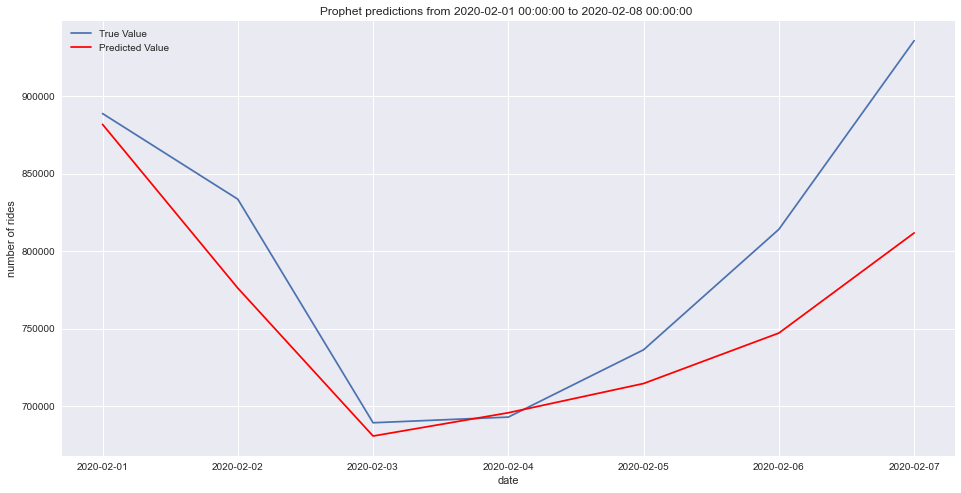

58270.01124426962

In [402]:
eval_prophet(df_train_9, df_test_9, holidays=False, periods=7, cap=1022363, plot=True)

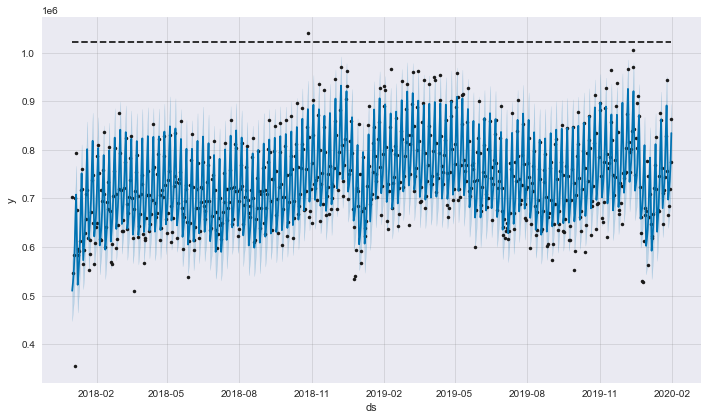

In [405]:
fig = model.plot(forecast)

In [410]:
rmse_list_prophet = []
mae_list_prophet = []
for i in range(len(train_sets)):
    rmse, mae = eval_prophet(train_sets[i], test_sets[i], plot=False)
    rmse_list_prophet.append(rmse)
    mae_list_prophet.append(mae)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/marthab/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/marthab/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/marthab/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbp

/Users/marthab/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


In [411]:
statistics.mean(rmse_list_prophet)

53717.70155875409

In [392]:
statistics.stdev(rmse_list_prophet)

22716.95301181113

In [419]:
avg_mase_prophet = mase(mae_list, mae_list_prophet)
avg_mase_prophet

1.0028444276852038

In [421]:
avg_mase_sarima = mase(mae_list, mae_list_sarima)
avg_mase_sarima

1.0263198997094256

In [415]:
mae_list_prophet

[48207.36513783202,
 37700.38754174557,
 40576.68303591211,
 37792.791119300025,
 24464.173769159177,
 65856.89292718125,
 89887.81171206087,
 19878.65664543915,
 40982.740316178846]

In [416]:
mae_list_sarima

[30166.806742320354,
 47966.25770387998,
 21229.1604280604,
 49896.07084239383,
 27531.290869949204,
 54266.60180208479,
 194845.13116707632,
 25196.493916867483,
 35953.04450661993]

In [417]:
mae_list

[40213.71428571428,
 46872.0,
 22300.39285714286,
 49860.485714285714,
 30998.535714285714,
 41419.75,
 84977.42857142857,
 57381.82142857143,
 61947.78571428572]

In [ ]:
# MASE, comparision with baseline model
def mase(baseline_mae_list, model_mae_list):
    mase_list = []
    for i in range(len(baseline_mae_list)):
        mase = model_mae_list[i]/baseline_mae_list[i]
        mase_list.append(mase)
        
    avg_mase = statistics.mean(mase_list)

    return avg_mase

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/marthab/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/marthab/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/marthab/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Test RMSE: 67297.633


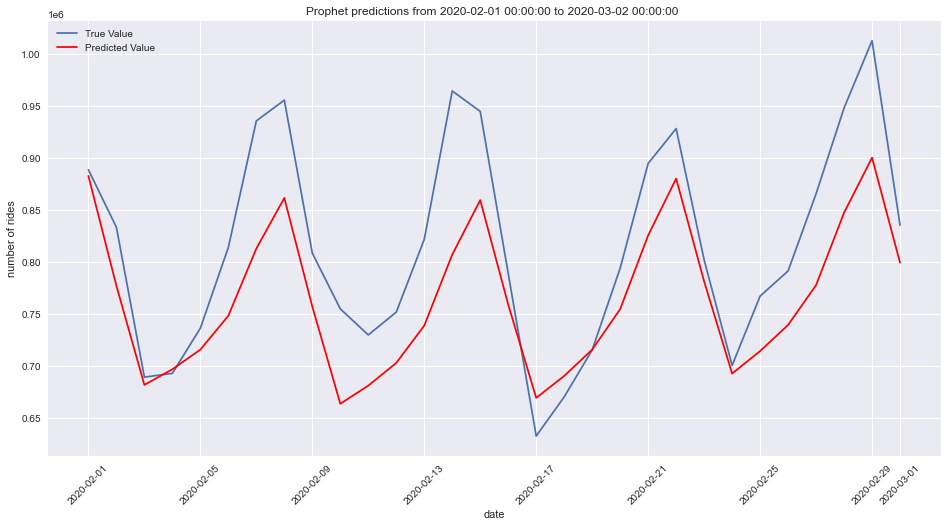

(67297.63280727138, 55264.111769400835)

In [462]:
eval_prophet(df_train_9, df_test_9, holidays=False, periods=30, cap=1022363, plot=True)